# Introduction to Classification with Logistic Regression

From the previous week, we established that the neural response to stimulus presentation produces a stereotyped pattern of electrical activity on the scalp. This was determined by taking the times when a stimulus was presented and calculating the average EEG activity around that time, known as the ERP. Since we know when the stimuli are presented, determining how the brain responds is fairly straight forward. What is not straight forward is going back the other direction: given the neural activity can we determine whether a stimulus was presented? This is the essential problem of BCI, and the one we will solve. And solving it for this case unlocks a host of new possibilities that, while analytically the same problem, are qualitatively different. It opens up the possibility to decode the identity of the presented stimulus, or a subject's intended action. This is as close to mind-reading as one can get. Let's get to work.

## What we will cover
The overarching goal of this week is to introduce simple logistic regression models, where a single feature derived from neural data (ERP strength) is used to predict a single predictor (stimulus present or absent). To start we will discuss different ways to quantify the strength of an ERP. We will also weigh the advantages and disadvantages of different approaches to extract time periods from the recording that lack stimuli. Then logistic regression will be introduced and we will cover how to apply it using the scikit-learn python package. Lastly, we will discuss some of general issues that arise in macine learning algorithms like logistic regression.

In [1]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.linear_model import LogisticRegression, LogisticRegressionCV
from sklearn.metrics import balanced_accuracy_score, confusion_matrix, matthews_corrcoef

## Quantification of ERP strength
ERPs have complex waveforms that can last a couple hundred milliseconds. With a sample rate of 500 Hz, that means we will have around 100 samples of neural data to work with when trying to determine whether a stimulus was present or not. You could imagine being given a set of wavefroms, some from trials with a stimulus and others without, and trying to determine which was which. One strategy is to calculate a feature of the waveform, and if it exceeds a prespecified value then the waveform is assigned to the stimulus group.

### Loading EEG data from stored Numpy arrays
As a starting point, we will use the data set we worked with last week. An auditory cue was given about every 8 seconds, and there was a robust ERP elicited over occipital and parietal EEG sites. We will select those epochs when we know a cue was presented, and an equal number of epochs where we know a cue was not delivered. To start, we need to load the data.

Last week we saved the EEG data as numpy arrays spread across several different files. Once the recording has been preprocessed to remove noise or detect eyeblinks, it is best to save it and work with it in its clean form. Now we will load it from one of our subjects.

In [2]:
load_dir = os.path.join(*['..', 'Week3', 'data', 'ds003690'])
subj = 'AB58'

chans = pd.read_csv(os.path.join(load_dir, subj + '_chans.tsv'), sep='\t', index_col='idx')
data = np.load(os.path.join(load_dir, subj + '_data.npy'))
srate = np.load(os.path.join(load_dir, subj + '_srate.npy'))
blinks = np.load(os.path.join(load_dir, subj + '_blinks.npy'))
cues = np.load(os.path.join(load_dir, subj + '_cues.npy'))

### Extracting non-stimulus times
To compare stimulus and non-stimulus periods, we need to select times when the stimulus did not occur. At first glance, this seems like a trivial task. Given the list of stimulus times, we can just create a new list by hand that does not include any of those times. However, we might unintentionally incorporate biases in our list creation. In addition, we want to avoid periods with blinks, because we exclude those periods from our ERP construction. This means we have to avoid two sets of conditions. But worst of all, we would have to create a new list for each recording session, which is tedious. We program to avoid tedium, so lets explore ways to automate this step.

The approach we devise to create no cue times should satisfy a few conditions:
1. The cue should not be present
2. No eyeblinks should be present
3. No systematic temporal relationship with cue delivery
3. No-cue epochs should have similar properties to cue epochs, such as:
    * Occur during the same period of the recording
    * Similar relative timing

But first, we will get the cue times that did not overlap with eye blinks.

In [3]:
# Function that returns cues without blinks
excl_blink = 0.6 # seconds, exclusion period surrounding a blink
rem_blinks = lambda c,b: np.array([ci for ci in c if not any(np.abs(ci-b) < excl_blink)])

# keep those cues that are not within the blink exclusion period
cues_nob = rem_blinks(cues, blinks)

The `blink_idxs` function can be used with our randomly generated times, but we also need to eliminate periods without cues. For this, we will create a similar function, but use a tighter exlusion period because of the tight temporal relationship between cue delivery and the ERP.

In [4]:
# create verions outside cue period
excl_cue = 0.1 # seconds, exclusion period around cue
rem_cues = lambda nc,c: np.array([nci for nci in nc if not any(np.abs(nci-c) < excl_cue)])
pre_win = 0.1 
post_win = 0.5 

#### Random strategy
For this approach, we will create a list of times using a random number generator. The random times we generate cannot have their window times extend past with the beginning or end of the recording, nor overlap with blink period or cue periods. We will use a fixed random seed when generating these times to ensure consitency across runs.

In [5]:
# set random seed, ensures consistent results across runs
np.random.seed(47)

# random times between 0 and recording duration
rec_dur = data.shape[1]/srate
cue_num = len(cues)
nocues_rand = np.random.uniform(pre_win, rec_dur-post_win, cue_num)
nocues_rand_nbc = rem_cues(rem_blinks(nocues_rand, blinks), cues)

We use the `random.uniform` random number generator in numpy to get as many times as we have cues (`cue_num`), and restricted to the range from the length of the pre-window (`pre_win`) till the end of the recording minus the duration of the post-window (`post_win`). Those times that overlap with cues or blinks are then removed, leaving a list of no-cue times that we can use. A good way to establish that the criteria for our no cue periods are followed is to plot the no-cue times overlaid on top of the cue times. 

Text(0.5, 1.0, 'Random no-cue times')

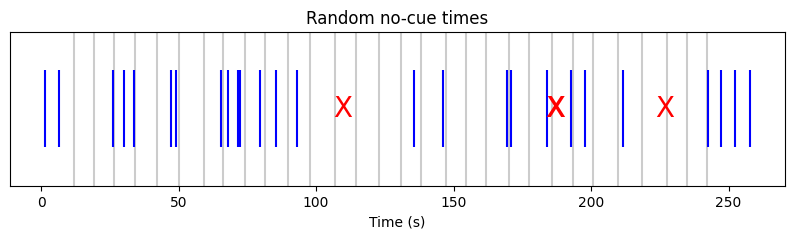

In [6]:
def plot_nocues(ax, nocues_orig, nocues_rem, cues):
    ax.vlines(cues, colors='k', ymin=-1, ymax=2, alpha=0.2) # cue times
    ax.eventplot(nocues_rem, colors='b') # no-cue times
    nocues_cut = np.setdiff1d(nocues_orig, nocues_rem) # cut no-cue times
    for nocue_cut in nocues_cut:
        ax.text(nocue_cut, 1, 'X', fontsize=20, color='r', ha='center', va='center')
    ax.set_ylim(0, 2)
    ax.set_yticks([])
    ax.set_xlabel('Time (s)')


fig, ax = plt.subplots(figsize=(10, 2))
plot_nocues(ax, nocues_rand, nocues_rand_nbc, cues)
ax.set_title('Random no-cue times')

In the above graph the graph vertical lines are the times when cues were presented, blue hatch marks are when valid random no-cue times occur, and red 'X's are the no-cue times that were eliminated due to overlapping with a cue or blink. If we compare the cue and no-cue times, it is apparent that the fourth criterion for good no-cue times is violated. One problem is that we have several no-cue times that occur outside the time period when the cue times were delivered (notice the two at the beginning and four at the end.) The other problem is that no-cue times are distributed unevenly, unlike the cues which are evenly spread across the recording session.

#### Permutation strategy
If we want to have the no-cue times have a similar distribution across the session as the cue times, we could generate random times but ensure that they have the same spacing between cues. One way to do this is to get a list of times between cue trials (inter-trial intervals, ITIs), shuffle those times, and then create a new list of times by adding them together one at a time. This strategy works because the times between cues are randomly generated, varying between 7 and 9 seconds. If cues are delivered at fixed times then randomly shuffling the ITIs would have no effect.

Text(0.5, 1.0, 'Permuted no-cue times')

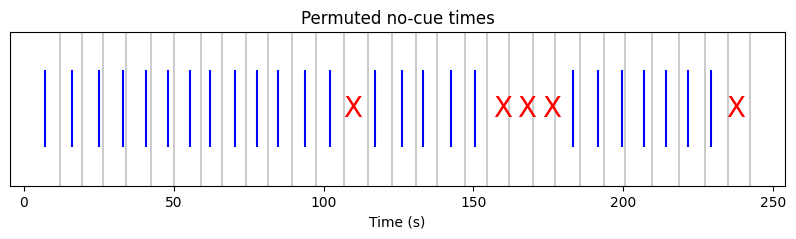

In [7]:
# set random seed, ensures consistent results across runs
np.random.seed(45)

# Calculate ITI times
# Note, we repeat the first ITI time so that when we sum the ITIs
# we get the correct number of trials
iti_times = np.insert(np.diff(cues), 0, cues[1]-cues[0])

# randomly shuffle the iti_times
iti_times = np.random.permutation(iti_times)

# get no-cue times by summing the iti_times.
# cumsum adds each element of the array to the previous element, 
# returning an array of the same size
nocues_perm = np.cumsum(iti_times)

# remove no-cue times that overlapped with cue times and blinks
nocues_perm_nbc = rem_cues(rem_blinks(nocues_perm, blinks), cues)

# plot permuted no-cue times
fig, ax = plt.subplots(figsize=(10, 2))
plot_nocues(ax, nocues_perm, nocues_perm_nbc, cues)
ax.set_title('Permuted no-cue times')

This looks much better than the purely random strategy. The no-cue times are during the same period when cues were presented, and have similar relative timing. However, they appear to sometimes overlap quite closely with the cue times. This leads us to the next stategy.

#### Fixed temporal offset
To ensure that our no-cue periods do not come close to the cue periods, we could set the no-cue times to be at a fixed time *before* each cue. If that time is greater than the post-window, and far enough from the previous cue time to ensure that it does not overlap with its ERP, this might work. This strategy would be questionable if the ITIs were at a fixed interval, because then there would be a systematic relationship between the cue times and no-cue times. But because they are random, that means the previous cue time will be random, plus or minus a second, with respect to the no-cue time. 

Text(0.5, 1.0, 'Fixed offset no-cue times')

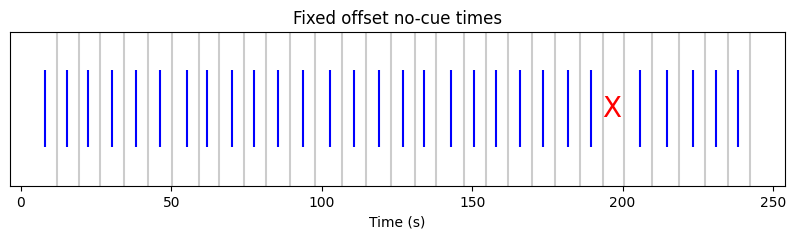

In [8]:
# fixed time before cue method
# fixed time should be less than the shortest iti minus the window.
fixed_time = 4 # half of the mean ITI
nocues_fixed = cues-fixed_time
nocues_fixed_nbc = rem_cues(rem_blinks(nocues_fixed, blinks), cues)

# plot permuted no-cue times
fig, ax = plt.subplots(figsize=(10, 2))
plot_nocues(ax, nocues_fixed, nocues_fixed_nbc, cues)
ax.set_title('Fixed offset no-cue times')

This looks good. Our no-cue periods are consistently far away from the cues and have a similar distribution as the cues across the session. We will use these times to get our no-cue epochs.

### Extracting EEG epochs
Last week we covered extracting EEG epochs, so we will only lightly reprise this here. This time we need one set of epochs centered on the cue times, and another on the no-cue times. Each will be a 3-D numpy array, where time is on 0-axis, channel is 1-axis, and trial on 2-axis. Since the number of samples has to be consistent across trials, we will convert all our times to samples and pull out the same number of samples per epoch to ensure this is the case. If we instead tried to calculate the start and stop times of each epoch in seconds, and the converted those to samples, rounding errors would introduce subtle differences in the number of samples taken per epoch.

In [9]:
# Calculate how many samples we need for each epoch
epoch_dur = int((pre_win + post_win) * srate)

# first get the cue epochs
cue_starts = ((cues_nob - pre_win) * srate).astype(int) # start at the pre-window timepoint, convert to int
cue_num = cue_starts.size

# create an array to hold data surrounding cue epochs
cue_epochs = np.zeros((epoch_dur, data.shape[0], cue_num))
for idx, c in enumerate(cue_starts):
    cue_epochs[:,:,idx] = data[:, c:(c + epoch_dur)].T


# next get the nocue epochs
nocue_starts = ((nocues_fixed_nbc - pre_win) * srate).astype(int)
nocue_num = nocue_starts.size

nocue_epochs = np.zeros((epoch_dur, data.shape[0], nocue_num))
for idx, c in enumerate(nocue_starts):
    nocue_epochs[:,:,idx] = data[:, c:(c + epoch_dur)].T

Instead of using all channels, we will focus only on a channel were the cue ERP was strong, O1. Let's plot the ERPs for the cue and no-cue epochs to make sure the ERP is only present for the cue.

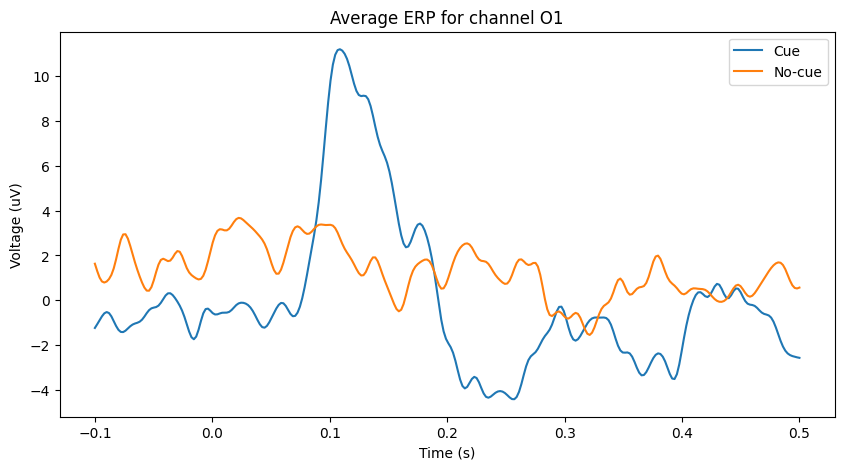

In [10]:
# Find the column corresponding to channel O1, where the ERP was strong
sel_chan = 'O1'
sel_chan_idx = chans.index.values[chans['name'] == sel_chan][0]

# get the average ERP for each condition
# note that selecting a single column with sel_chan_idx reduces 
# the dimensionality of cue epochs from 3 to 2.
cue_erp = np.mean(cue_epochs[:, sel_chan_idx, :], axis=1) 
nocue_erp = np.mean(nocue_epochs[:, sel_chan_idx, :], axis=1)
t_erp = np.linspace(-pre_win, post_win, epoch_dur)

# plot the ERPs
plt.figure(figsize=(10, 5))
plt.plot(t_erp, cue_erp, label='Cue')
plt.plot(t_erp, nocue_erp, label='No-cue')
plt.xlabel('Time (s)')
plt.ylabel('Voltage (uV)')
plt.title('Average ERP for channel ' + sel_chan)
plt.legend()

So far so good. We can see that the ERP is strong for epochs centered on the cue, and non-existent for random times that avoid cue presentation.

### Quantifying ERP strength
The next step is to distill the complex ERP waveform into a single number that reflects its strength. There are numerous measures you can use for this, and we will explore a few. This step is known as feature engineering, wherein we try to distill multidimensional samples to a few values that capture the aspects of the sample that are relevant to our task. In this case, each sample is a collection of 300 voltage measurements, and the aspect we want to measure is the strength of the ERP. A good feature will take on values that distingquish between the cue and no cue epochs.

#### Voltage at ERP peak time
Since we know the shape of the ERP, we know on average where it tends to peak in value. The voltage at that time should indicate whether an ERP is present. Looking at the average ERP traces immediately above, you can see that on trials with a cue the voltage will tend to be near 10 uV at the peak time, while on no-cue trials it will tend to be near 2 uV. To get the peak voltage on each trial, we first find the time when the ERP peak occurs, then sample the voltage at that time for each epoch.

In [11]:
# get peak idx of cue erp
cue_peak_idx = np.argmax(cue_erp)

# return the voltages at the ERP peak time
cue_erp_peaks = cue_epochs[cue_peak_idx, sel_chan_idx, :]
nocue_erp_peaks = nocue_epochs[cue_peak_idx, sel_chan_idx, :]

To examine how well the peak voltage distinquishes between the Cue and No-cue conditions, we can plot their distribution. The less their respective distributions overlap, the better the feature is for distinguishing between the types of trials.

Text(0.5, 1.0, 'Peak Amplitude of Cue and No Cue Conditions')

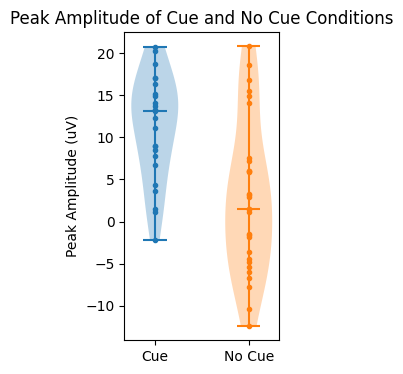

In [12]:
# box plot of peak values for cue and nocue conditions with event plot of points on top
def plot_dist_erps(cue_vals, nocue_vals, ax=None):
    if ax is None:
        fig, ax = plt.subplots()

    # violin plot of values, with cue_vals blue and nocue_vals orange
    cue_vp = ax.violinplot(cue_vals, positions=[1], showmedians=True)
    for pc in cue_vp['bodies']:
        pc.set_facecolor('tab:blue')

    nocue_vp = ax.violinplot(nocue_vals, positions=[2], showmedians=True)
    for pc in nocue_vp['bodies']:
        pc.set_facecolor('tab:orange')
    
    # plot the cue_vals and nocue_vals as points on top of the violin plot
    ax.plot(np.ones(len(cue_vals)), cue_vals, '.', color='tab:blue')
    ax.plot(2 * np.ones(len(nocue_vals)), nocue_vals, '.', color='tab:orange')
    # set the xticks to be at 1 and 2, with labels Cue and No Cue
    ax.set_xticks([1, 2])
    ax.set_xticklabels(['Cue', 'No Cue'])

fig, ax = plt.subplots(figsize=(2, 4))
plot_dist_erps(cue_erp_peaks, nocue_erp_peaks, ax=ax)
plt.ylabel('Peak Amplitude (uV)')
plt.title('Peak Amplitude of Cue and No Cue Conditions')

The violin plot above shows a smoothed distribution of the data points as a shaded region. The solid horizontal lines from top to bottom are the maximum, median, and minimum values. The distributions do overlap, with the median value for the No-cue condition falling within the distribution of values for the Cue. This overlap is likely because there is substantial spontaneous activity in the EEG signal that is added to our ERP peak estimate on each trial. When we got the average ERP, this spontaneous activity that was not time-locked to cue delivery canceled out because it was equally likely to be positive or negative. We can visualize this spotaneous component by plotting the EEG signal for each epoch with the ERP subtracted out. That looks like:

/var/folders/xr/cvz2q4cs7mn5n78kvjyvkb_00000gn/T/ipykernel_82654/2955384320.py:16: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax['r'].set_yticklabels(range(-30, 40, 10))


Text(0.02, 0.5, 'Voltage (uV)')

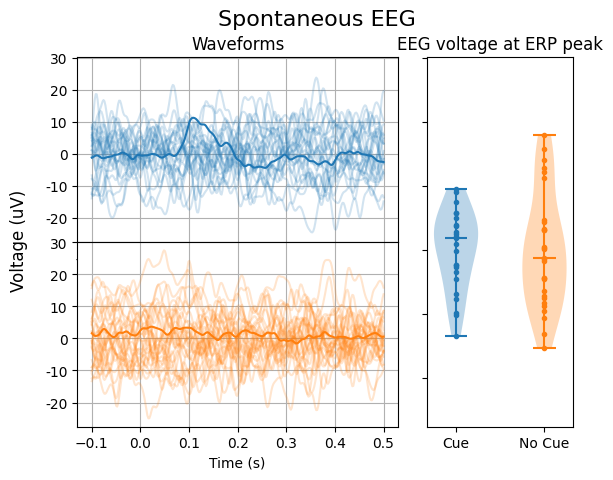

In [13]:
# subtract the mean ERP waveform from each epoch
# epochs have to be transposed, x.T, because of broadcasting rules in numpy
cue_epochs_spon = cue_epochs[:,sel_chan_idx,:].T-cue_erp
nocue_epochs_spon = nocue_epochs[:,sel_chan_idx,:].T-nocue_erp

# plot EEG without ERP, and distribution of values where ERP peak would be
fig, ax = plt.subplot_mosaic([['ul', 'ul', 'r'],['ll', 'll', 'r']], sharey=True)
ax['ul'].plot(t_erp, cue_epochs_spon.T, color='tab:blue', alpha=0.2)
ax['ul'].plot(t_erp, cue_erp, color='tab:blue')
ax['ul'].grid()
ax['ll'].plot(t_erp, nocue_epochs_spon.T, color='tab:orange', alpha=0.2)
ax['ll'].plot(t_erp, nocue_erp, color='tab:orange')
ax['ll'].grid()
ax['ll'].set(xlabel='Time (s)')
plot_dist_erps(cue_epochs_spon[:,cue_peak_idx], nocue_epochs_spon[:,cue_peak_idx], ax=ax['r'])
ax['r'].set_yticklabels(range(-30, 40, 10))
fig.subplots_adjust(hspace = 0)
ax['ul'].set(title='Waveforms')
ax['r'].set(title='EEG voltage at ERP peak')
fig.suptitle('Spontaneous EEG', fontsize=16)
fig.supylabel('Voltage (uV)')

After removing the ERP, a a great deal of variation still remains, with an amplitude on par with the ERP itself. In fact, the shape of the distribution of EEG voltages at the ERP peak time is the same as the one for the ERPs above. This is a simple consequence of the ERP peak values reflecting the sum of the mean ERP peak and the spontaneous EEG at that time. When we substract the mean ERP peak, we are just shifting the distribution to zero. Is there anyway we can minimize the spontaneous EEG activity on a single trial? 

#### Average voltage during ERP
Examining the spontaneous EEG waveforms, we see that the signal fluctuates betwen positive and negative values on the order of tens of milliseconds. Perhaps if we average the EEG signal over the 100 ms when the strongest ERP component is present, from 80 to 180 ms, the spontaneous activity will cancel itself out. The ERP, on the other hand, maintains positive values during that period, so it should persist despite the averaging. The logic here is similar to averaging the EEG epochs across trials, because the spontaneous voltage at each time point across epochs will randomly vary between positive and negative values. In this case, we are just applying that principle across time within a trial.

When we restrict analysis or calculation to a specific time window, that period is referred to as the *region of interest* (ROI). Here, our ROI will be from 80 to 180 ms post cue (or no-cue), and we will take the mean value of the EEG voltage during that time.

Text(0.5, 1.0, 'Mean amplitude of Cue and No Cue Conditions')

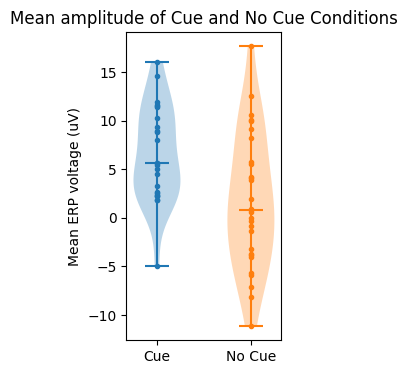

In [14]:
# get indices between 80 and 180 ms
roi_idxs = np.where((t_erp >= 0.08) & (t_erp <= 0.18))[0]

# get the mean EEG voltage during the strongest ERP component across trials for each condition
cue_erp_means = np.mean(cue_epochs[roi_idxs, sel_chan_idx, :], axis=0)
nocue_erp_means = np.mean(nocue_epochs[roi_idxs, sel_chan_idx, :], axis=0)

# plot mean voltages
fig, ax = plt.subplots(figsize=(2, 4))
plot_dist_erps(cue_erp_means, nocue_erp_means, ax=ax)
plt.ylabel('Mean ERP voltage (uV)')
plt.title('Mean amplitude of Cue and No Cue Conditions')

Well that did not work. Averaging over the period where the strongest ERP component was present diminished median peak ERP voltage for the Cue condition, making it less separable from the No-cue condition. This happens because the magnitude of the ERP varies across time, and we are averaging together periods where it is weaker. Indeed, if we calculate the mean of the ERP during our ROI:

In [15]:
# get mean of ERP during the ROI
erp_mean = np.mean(cue_erp[roi_idxs])
print("Mean of ERP during ROI: {:.2f}".format(erp_mean))

# get ERP voltage during its peak
erp_peak = cue_erp[cue_peak_idx]
print("ERP voltage during peak: {:.2f}".format(erp_peak))


Mean of ERP during ROI: 6.52
ERP voltage during peak: 11.21


We have gone from an ERP peak voltage of 11.2 to 6.5 uV, a decrease by almost half! While this might tempt us to go back to the original approach of just sampling the voltage at the ERP peak, we would leave behind one advantage of the avering approach: it reduced the variability in the distribution of ERP values. This is evident when we compare the standard deviations of the distributions between the ROI mean and peak estimation approaches.

In [16]:
# variance of ERP ROI means
cue_erp_means_var = np.std(cue_erp_means)
nocue_erp_means_var = np.std(nocue_erp_means)

# variance of ERP peaks
cue_erp_peaks_var = np.std(cue_erp_peaks)
nocue_erp_peaks_var = np.std(nocue_erp_peaks)

# print comparisons
print('Cue ERP ROI {:.2f} vs peaks {:.2f} uV'.format(cue_erp_means_var, cue_erp_peaks_var))
print('No-cue ERP ROI {:.2f} vs peaks {:.2f} uV'.format(nocue_erp_means_var, nocue_erp_peaks_var))

Cue ERP ROI 4.80 vs peaks 6.04 uV
No-cue ERP ROI 6.77 vs peaks 8.80 uV


Taking the mean over the ROI reduced the variability in our ERP measures, which should improve our ability to discriminate between cue and no-cue trials. 

Is there a way we can benefit from averaging over multiple samples to get a measure of ERP strength, while not diminishing the strength of the ERP itself?

#### Dot product of ERP
One way to average over multiple samples while not diminishing ERP strength is to weigh each time point by the value of the ERP. This would measure the alignment between EEG and the mean ERP. Here we determine the strength of the ERP by multiplying each datapoint by its corresponding voltage in the ERP. If we are at a sample where the ERP is strongly positive, then we want that point to stongly contribute the mean, while a point where the ERP is weak should contribute less. If the ERP is negative at a certain time point, we want to negate that sample so it will constructively add to the mean. By doing this, if the EEG contains a signal that follows the waveform of the ERP it will return a strong mean value, while an EEG signal that does not follow the ERP time course will return a weak mean. 

A mathematical operation that can be used to do this is called the *dot product*. A dot product multiplies together each corresponding element in two vectors, $x$ and $y$, and then adds those together, returning a scalar $z$.

$$ \begin{align}
    \notag z &= x \cdot y \\
    \notag  &= \sum_{i=1}^{n}x_{i}y_{i}
\end{align}
$$

Let's explore how to calculate a dot product and its behavior.


In [17]:
# how to code a dot product in base python
def dot(x, y):
    """
    Calculate the dot product of two vectors x and y
    """

    out = 0
    for x_i, y_i in zip(x, y):
        out += x_i * y_i

    return out


v1 = [1, 2, 3]
v2 = [1, 2, 3]
print('Dot product of two aligned vectors, {} and {} = {}'.format(v1,v2,dot(v1, v2)))

v1 = [1, 2, 3]
v2 = [2, 2, 2]
print('Dot product of two partly aligned vectors, {} and {} = {}'.format(v1,v2,dot(v1, v2)))

v1 = [1, 2, 3]
v2 = [-1, 2, -1]
print('Dot product of two misaligned vectors, {} and {} = {}'.format(v1,v2,dot(v1, v2)))

Dot product of two aligned vectors, [1, 2, 3] and [1, 2, 3] = 14
Dot product of two partly aligned vectors, [1, 2, 3] and [2, 2, 2] = 12
Dot product of two misaligned vectors, [1, 2, 3] and [-1, 2, -1] = 0


Instead of rolling our own, we will use the numpy array dot function, `dot`, because it handles dot products on multidimensional arrays. 

To calculate the alignment between an EEG epoch and the mean ERP, we use the ERP waveform as our weighting vector. We will scale its values by its *euclidean norm*, so that the values returned by our dot product are in a comparable range to those from the peak and mean calculations we did previously. The euclidean norm is:

$$ ||x|| = \sqrt{\sum_{i=1}^{n}{x_{i}^{2}}} $$

This function is implemented in the linear algebra portion of the numpy package as `linalg.norm`.

Thus, the alignment between an EEG epoch and ERP is:

$$ Alignment = EEG \cdot \frac{ERP}{||ERP||} $$

Let's give it a try.

Text(0.5, 1.0, 'Dot product of Cue and No Cue Conditions')

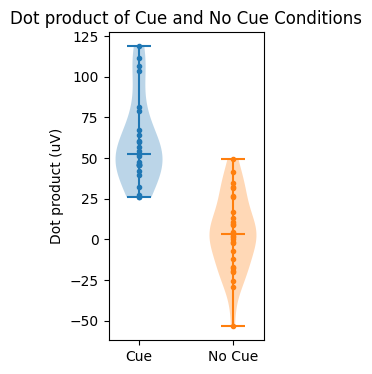

In [18]:
# our function that measures the alignment between the EEG epoch and ERP
def erp_align(epochs, erp):
    return np.dot(epochs.T, erp/np.linalg.norm(erp))

# EEG voltage for each epoch
cue_epochs_O1 = cue_epochs[:, sel_chan_idx, :]
nocue_epochs_O1 = nocue_epochs[:, sel_chan_idx, :]


cue_erp_dots = erp_align(cue_epochs_O1, cue_erp)
nocue_erp_dots = erp_align(nocue_epochs_O1, cue_erp)

# box plot of peak values for cue and nocue conditions with event plot of points on top
fig, ax = plt.subplots(figsize=(2, 4))
plot_dist_erps(cue_erp_dots, nocue_erp_dots, ax=ax)
plt.ylabel('Dot product (uV)')
plt.title('Dot product of Cue and No Cue Conditions')

These two distributions seem much more separable than the previous ones. The median values for the Cue and No-cue conditions do not overlap with the distribution of the opposite condition, and their overall distributions overlap less as well. Replotting all three together highlights the improvement we have made in tailoring the feature we extract from the EEG for detecting the Cue-evoked ERP.

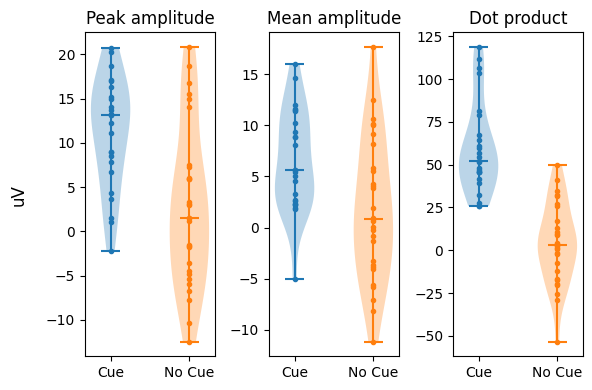

In [19]:
fig, ax = plt.subplots(1,3,figsize=(6, 4))
plot_dist_erps(cue_erp_peaks, nocue_erp_peaks, ax=ax[0])
ax[0].set_title('Peak amplitude')
plot_dist_erps(cue_erp_means, nocue_erp_means, ax=ax[1])
ax[1].set_title('Mean amplitude')
plot_dist_erps(cue_erp_dots, nocue_erp_dots, ax=ax[2])
ax[2].set_title('Dot product')
fig.supylabel('uV')
fig.tight_layout()

## A simple decision model
Our goal is to determine whether a trial had a cue stimulus or not. The dot product feature seems to distinguish between trial types, so if know the its value on a given trial we can determine with some confidence whether the cue was present. This is a decision process, where we assign a trial to either the Cue or No-cue category depending on the value of the dot product. A simple way to make this decision is to set a threshold value for the dot product, above which the trial is classified as a Cue trial. If the value is below the threshold, we label it a No-cue trial. This can be represented as a piecewise mathematical formula:

$$ f(x,t) = \left \{
\begin{array}{ll}
    0 & x\leq t \\
    1 & x\gt t \\
\end{array}
\right.    
$$

Here $x$ is the dot product of the epoch, and $t$ is the threshold. When the function returns a 1 we refer to it as a Cue trial, while a 0 is labeled a No-cue trial. We have to choose a threshold, and to start we will use the minimum dot product of our Cue trials.

In [35]:
# set threshold
thresh = np.min(cue_erp_dots)

# create vectors for ERP values and class labels
cue_num = cue_erp_dots.size # number of cue trials
nocue_num = nocue_erp_dots.size # number of nocue trials
class_act = np.repeat([True, False], [cue_num, nocue_num]) # actual class labels, 1 for cue, 0 for nocue
vals = np.append(cue_erp_dots, nocue_erp_dots) # ERP values
class_min_pred = vals > thresh # predicted class labels

# print the true vs. predicted class labels
print('Actual class labels: ', class_act)
print('Predicted class labels: ', class_min_pred)

Actual class labels:  [ True  True  True  True  True  True  True  True  True  True  True  True
  True  True  True  True  True  True  True  True  True  True  True  True
  True False False False False False False False False False False False
 False False False False False False False False False False False False
 False False False False False False]
Predicted class labels:  [ True  True  True  True  True  True  True  True  True  True  True  True
  True  True  True  True  True  True  True  True  True  True  True False
  True False False  True False  True False False False False False False
  True  True False False False False False False  True False  True  True
 False False False False False False]


If you look closely, you can see that some of our predicted classes do not agree with the true ones. There are different types of errors a classifier can make, and numerous ways to measure the their performance. We will start with two simple measures, *error rate* and *accuracy*. Error rate is the proportion of trials that were misclassified. This can be defined mathematically as:

$$ Error Rate = \frac{1}{n}\sum_{i=1}^{n}{I(y_{i}\ne \hat{y_{i}})} $$

Here $y$ is the actual class labels and $\hat{y}$ are the predicted class labels. The function $I(x,y)$ returns a 1 when $x \ne y$, and 0 when $x=y$. Summing across all trials and dividing by the total number of trials, $n$, gives the proportion of trials whose predicted class disagreed with its actual class. 

Another helpful measure is accuracy, which is simply the proportion of trials where the predicted and actual class labels agreed. Expressed as:

$$ Accuracy = 1 - Error Rate $$

How does our simple classifier perform based on these metrics?

In [34]:
# as an example, here we define error rate method with base python
def error_rate_base(y_act, y_pred):
    er = 0
    for i in range(len(y_act)):
        if y_act[i] != y_pred[i]:
            er += 1
    return 100 * er / len(y_true)

# define error rate method with numpy
def error_rate(y_act, y_pred):
    return np.mean(y_act != y_pred) * 100

# define accuracy method with numpy
def accuracy(y_act, y_pred):
    return 100-error_rate(y_act, y_pred)

In [36]:
# evaluate error rate for ERP peak
# 1 for cue trials, 0 for non-cue trials
er_min = error_rate(class_act, class_min_pred)
ac_min = accuracy(class_act, class_min_pred)

print('Error rate for ERP peaks: {:.1f}%'.format(er_min))
print('Accuracy for ERP peaks: {:.1f}%'.format(ac_min))

Error rate for ERP peaks: 14.8%
Accuracy for ERP peaks: 85.2%


Not too bad. Just setting our threshold to the minimum value of from the Cue trials, we can correctly classify ~85% of trials. But, how do we know we have chosen the best threshold? Moreover, can we ascertain how confident our classifier is in the choice it puts out? To address these issues, we need to formalize the classification process. One approach is to use *logistic regression*, which takes a measurement (e.g. ERP dot product) and returns the *probability* that it was generated by class (e.g. cue stimulus). For this week, we will pose the problem and learn how to use the logistic regression functions in the scikit-learn package. 

## Binary classification 
A binary classifier takes a set of measurements, $x$, as inputs and returns the probability that they were generated by a specific class, $\hat{y}$. (This is known as the *discriminative view* of classification. We will make of the *generative view* later in the semester when we tackle Naive Bayes classifiers.) To get from $x$ to $\hat{y}$, we need a function that describes the *probability* of the class occuring over a range of measurement values.

### A quick probability primer
Probabiltilies describe how likely events are to occur. They range from 0, for events that never happen, to 1, for events that are guaranteed to happen. When quantifying probabilities we do this for a class of events, with the total probability across all events adding up to 1 (which means that at any time one of them has to occur). For instance, in the case of flipping a coin, there is a 0.5 (1/2 or 50%) chance that the coin will come up Heads, and 0.5 that it will be Tails. These are the only possibilities (this is a Platonic coin, so it has no thickness and thus cannot land on its side). A coin flip is a good example of an *unconditional probability*, which is the same regardless of the circumstances. For this, we would write: 

$$\begin{align}
p(H)&=0.5 \\
p(T)&=0.5 \\
\end{align}
$$

which says that the probability of the coin coming up heads, $p(H)$, is 0.5, and the probability of coming up tails, $p(T)$, is 0.5. 

But probabilities can also depend on the situation, such as the probability that you will buy lunch at a certain time. It is more likely that you will purchase lunch at 11:30 AM than at 10:00 AM. This is a *conditional probability*. Conditional probabilities are expressed as $P(Lunch|Time)$, which translates as the probability of going for Lunch, ($Lunch$), is conditional, $|$, on the time, $Time$. For a conditional probability we need to know the time to give the probability that we are going to lunch.

In the case of our ERP decoder, you can say that the probability of a trial having a cue is conditional on the strength of its ERP, p(Cue|ERP). For this, we need an equation that describes how the probability of being a Cue trial varies as a function of ERP strength.

### Logistic function
One equation that is a useful way to express a conditional probability is the *logistic function* (also known as the sigmoid function). It has the form:

$$ \sigma(x) = \frac{1}{1+e^{-x}} $$

Let's code it up and visualize it:

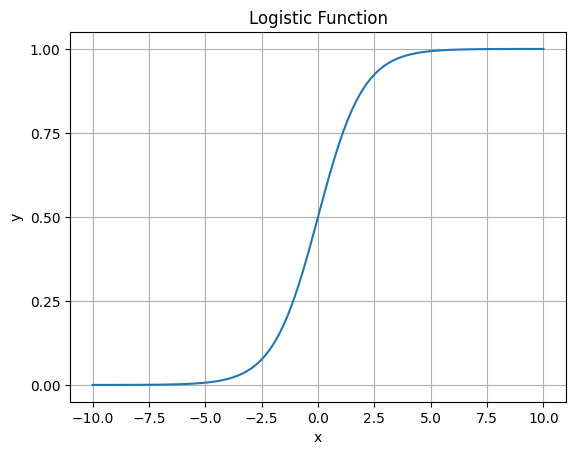

In [14]:
# create a logistic function
def logistic(x):
    return 1 / (1 + np.exp(-x)) 

# plot the logistic function
x = np.linspace(-10, 10, 100)
plt.plot(x, logistic(x))
plt.title('Logistic Function')
plt.yticks(np.arange(0, 1.1, 0.25))
plt.xlabel('x')
plt.ylabel('y')
plt.grid()
plt.show()

This function is bounded between 0 and 1, just like probabilities. However, by itself it is not useful. It also has a probability of 0.5 when $x=0$, which is not good for us because our decision point, called the *location parameter*, for a cue trial usually had our ERP measure at a positive value.

To shift the location, we can modify x by subtracting the location value from it.

$$ \sigma(x) = \frac{1}{1+e^{-(x-loc)}}$$

How does this look?

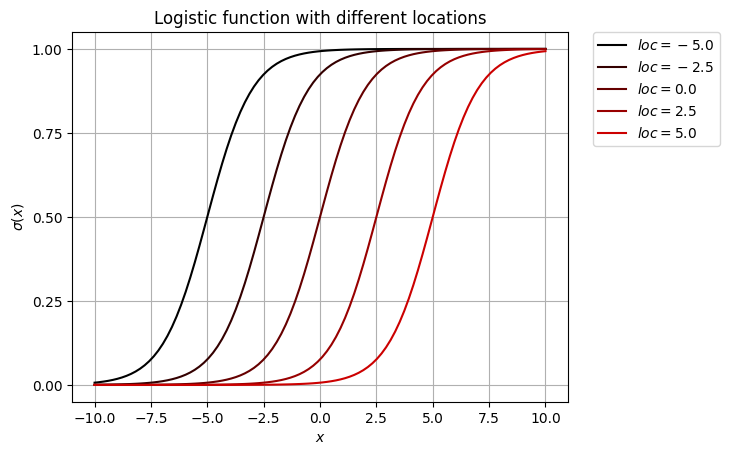

In [40]:
# create logistic functio with adjustable location
def logistic(x,loc=0):
    return 1/(1+np.exp(-(x-loc)))

# plot logistic function with different locations
loc_list = np.arange(-5,6,2.5)
x = np.linspace(-10,10,100)

for ind, loc in enumerate(loc_list):
    plt.plot(x,logistic(x,loc),label='$loc={}$'.format(loc), color=[ind/len(loc_list), 0, 0])

plt.yticks(np.arange(0,1.1,0.25))
plt.xlabel('$x$')
plt.ylabel('$\sigma(x)$')
plt.title('Logistic function with different locations')
plt.grid()
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0)

This looks promsing, we can shift the point at which the logisitc function crosses 0.5. However, the range of $x$ values overwhich the logistic function varies, its *scale*, is narrow compared to the range of values we get for our dot product measures of the ERP. This may not seem important now, since a simple classification threshold at 0.5 probability does not care about the spread in our logistic function. But, if we want our function to characterize $p(Cue|ERP)$, then this matters. Adjusting the scale is straightforward with the addition of a new parameter.

$$ \sigma(x)=\frac{1}{1+e^{-\frac{x-loc}{scale}}} $$

By dividing $x-loc$ by $scale$, we can stretch or contract the logisitc function with respect to the x-axis. As you increase $scale$, the values of $x$ have to get larger to push the output closer to 0 or 1. If you decrease $scale$, when only a small change in $x$ is needed to have the logisitic function return 0 or 1. We can see this below: 

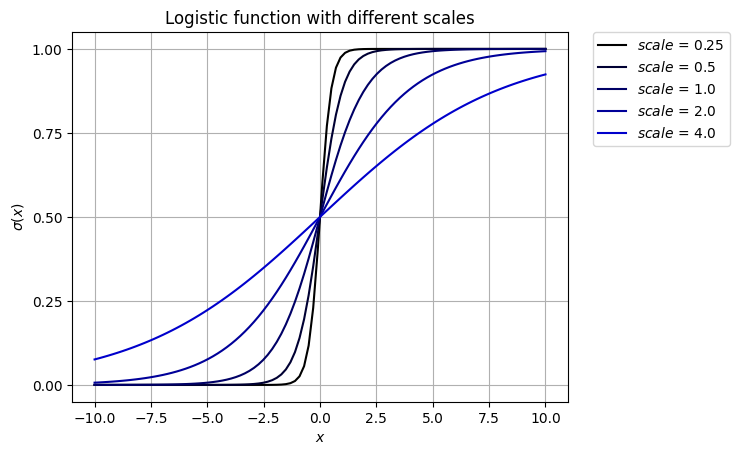

In [39]:
# logistic function with location and scale parameters
def logistic(x, loc=0, scale=1):
    return 1 / (1 + np.exp(-(x - loc) / scale))

# plot the logistic function
x = np.linspace(-10, 10, 100)
loc = 0
scale_list = np.power(2.0, range(-2, 3, 1))

for ind, scale in enumerate(scale_list):
    plt.plot(x, logistic(x, loc, scale), label='$scale$ = {}'.format(scale), color=[0, 0, ind / len(scale_list)])
plt.yticks(np.arange(0, 1.1, 0.25))
plt.xlabel('$x$')
plt.ylabel('$\sigma(x)$')
plt.grid()
plt.title('Logistic function with different scales')
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0)

Great, we can change the spread of the logistic function now. With these two degrees of freedom, location and scale, we are able to create a function that captures the probability of a certain class (in our case, a cue trial) occuring. An important caveat to this function is that it is monotonic, meaning that the probability of being that class only increases (or decreases) as one increases the value of $x$. This works for most cases, but not if our class occurs for only a restricted range of $x$ values (e.g. between 2 and 5). But don't worry, later we will cover a few tricks that circumvent this limitation.

## Fitting the logistic function
Using the logistic function requires us to choose values for the location and scale parameters, which we *could* try doing by hand. That is not recommended. Instead, we will use the `LogisticRegression` class in the scikit-learn package. This class defines an object that can take our measurements and true classes, fit a logistic function to that data, and then deliver class predictions. To start using this, we will cover how scikit-learn implements its fitting functions in general, and then the specifics of the `LogisticRegression` class.

### Scikit-learn standards
Scikit-learn is a python package started in 2007 and has grown to include a wide variety of machine learning algorithms. Most of these are implemented as *estimators*, which are classes that allow one to fit a model or function to some data and then make predictions from that model. The project has adopted a uniform standard for the creation of estimators, making it easier to incorporate new ones into the project or develop your own that will comprehensible to users already familiar with scikit-learn. For details you can check out the online documentation for developers (https://scikit-learn.org/stable/developers/develop.html).

Each estimator has an `__init__` method that creates the estimator object. When calling this method, you can pass settings parameters that determine how the estimator will fit to the data. Generally, these settings are supposed to be independent of the data being fit to. The estimator then has a `fit` function, which accepts a data matrix `X` and predicted classes `y`. Additional parameters can be set here that affect the fitting process in ways specific to the data. Once the `fit` function has been called, you can evaluate the performance of the fit using the `score` method, or predict new classes from new data using the `predict` method.

We will step through these using the `LogisticRegression` class to fit our predictor of of whether a cue was present on a trial given the ERP.

### Initializing
To use the `LogisticRegression` class, we need to create an instance of it as an object. Parameters specifying how to fit the function to your data, using set using the `__init__` method, but also accessible with a `set_params` method after you created the estimator. When no parameters are given to initialize the object. 


In [41]:
# create a vanila LogisticRegression object
clf = LogisticRegression()

# examine its default fitting parameters
clf.get_params()

{'C': 1.0,
 'class_weight': None,
 'dual': False,
 'fit_intercept': True,
 'intercept_scaling': 1,
 'l1_ratio': None,
 'max_iter': 100,
 'multi_class': 'auto',
 'n_jobs': None,
 'penalty': 'l2',
 'random_state': None,
 'solver': 'lbfgs',
 'tol': 0.0001,
 'verbose': 0,
 'warm_start': False}

The only one worth mentioning at this time is `fit_intercept`, which determines if we will include a location parameter in our fitting. By default this is set to True, so we don't have to worry about explicitly setting it.

### Fitting
Now that we have our `LogisticRegression` object, we can call its `fit` method. It accepts arrays containing your indepdentent, $x$, and dependent, $y$ variables and optimizes the function to best fit that data. Fit accepts two inputs. First is `X`, which is an array of measurements. It has 2 dimensions, with each row a different *sample* (e.g. trial), and each column a different *feature* (e.g. ERP peak voltage). Its shape is (n_samples, n_features), where 'n' stands for number. You can have multiple features per sample, which allows us to use more than one aspect of the measured brain activity on a trial to decode whether a stimulus was present.

The next input is `y`, the true class labels (e.g. Cue or NoCue) labels. Its shape is (n_samples,), where n_samples is the same as `X`. Notice that `X` is uppercase and `y` is lowercase. This is because a common notational convention is that a matrix (a 2-D array) is represented by an uppercase character, while vectors (1-D array) use lowercase characters.

In [48]:
# format X
# add dimension to X, because X needs to be a 2D array
vals = vals[:, np.newaxis]
print('The shape of X is {}'.format(vals.shape))

# class_act is already formatted correctly
print('The shape of y is {}'.format(class_act.shape))

# fit the model
clf.fit(vals, class_act)

The shape of X is (54, 1)
The shape of y is (54,)


LogisticRegression()

That's it, we fit the model! A bit anticlimatic, since all we did was update the `clf` object with a fitted model. The next thing we need to do is evaluate the performance of the fitted model.

### Evaluating
There are couple ways to judge the performance of our model. When we implemented our simple thresholded decision model above, we used error rate and accuracy as our measures. The `LogisticRegression` class provides a method named `score` that can calculate accuracy. It accepts `X` and `y` parameters similar to the `fit` method. Note: you do not have to provide the same `X` and `y` used for `fit`, but can use new data that the model was not trained on (in fact, this is a better practice as we will discuss later). It returns a number between 0 and 1, with 1 being perfect classification, and 0 being totally incorrect classification. This single number provides a good topline indication of whether the fit was successful. Poor accuracy will usually not be at 0, but at a level consisent with random guessing. For binary decoding with equal numbers of each class, this would be 0.5.

In [49]:
# calculate the score for our model
score = clf.score(vals, class_act)

print('Accuracy for our model: {:.2f}%'.format(score*100))

Accuracy for our model: 87.04%


The logisitc regression decoder out performs our simple threshold classifier we set by eye, which was 85.2%. Not by much, but better nonetheless. Just as a sanity check, let's see what happens if we scramble the actual class labels. In this case, the performance of the classifier should be random.

In [57]:
score_rand = clf.score(vals, np.random.permutation(class_act))

print("Random prediction accuracy: %.2f%%" % (score_rand * 100))

Random prediction accuracy: 50.00%


If we run this cell a few times we can see that the average accuracy is around 50%, which is what we would expect from random performance. However, random performance of a binary classifier does not need to be at 50%. If there are more of one of the classes over the other, then the decoder could perform better than 50% just by chance. 

In [83]:
# remove no-cue trials
vals_mod = vals[:-20].copy() # remove last 10 trials, which are no-cue trials
class_act_mod = class_act[:-20].copy() # remove last 10 trials, which are no-cue trials

clf.fit(vals_mod, class_act_mod)
score_mod = clf.score(vals_mod, class_act_mod)
print('Accuracy for our model: {:.2f}%'.format(score_mod*100))

score_rand = clf.score(vals_mod, np.random.permutation(class_act_mod))
print('Accuracy for random model: {:.2f}%'.format(score_rand*100))


Accuracy for our model: 94.12%
Accuracy for random model: 64.71%


Notice that the accuracy has gone up for our model, and for the random case. This is because the model can optimize its performance simply by biasing its response to be Cue trials instead of No-cue trials. This works because the data set is unbalanced, with much fewer No-cue trials compared with Cue trials. 

Is there a way to account for this? The metrics section of scikit-learn provides a range of performance score functions that measure other aspects of classifier performance or control for issues in the data set. In this case, we are dealing with unbalanced data. To address that, we can use the function `balanced_accuracy_score`. It works by calculating the accuracy for each class separately, and then taking the average across classes. In this way, if one class is overexpressed and classified correctly more often due to bias, then its contribution to the accuracy score will be downgraded, while the less well represented class with is biased against will have its score enhanced. Specifically, for the binary classification we are doing here, the is is calculated using the following equation:

$$ Balanced Score = \frac{1}{2} \left( \frac{TP}{TP+FN}+\frac{TN}{TN+FP}  \right) $$

In [93]:
class_pred_mod = clf.predict(vals_mod)
score_bal = balanced_accuracy_score(class_act_mod, np.random.permutation(class_pred_mod))
print("Balanced accuracy score: {:.2f}".format(score_bal*100))

Balanced accuracy score: 51.11


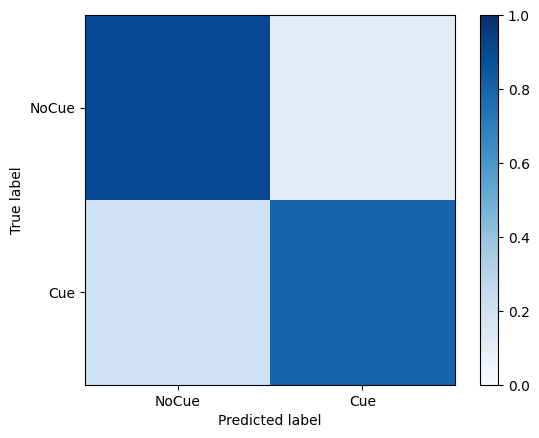

Balanced accuracy score: 84.83
Balanced accuracy score (random): 55.31


In [21]:
y_pred = clf.predict(X)

confu_mat = confusion_matrix(y, y_pred, normalize='true')

plt.imshow(confu_mat, cmap=plt.cm.Blues, vmin=0, vmax=1)
plt.colorbar()
plt.xlabel("Predicted label")
plt.ylabel("True label")
plt.xticks([0, 1], ["NoCue", "Cue"])
plt.yticks([0, 1], ["NoCue", "Cue"])
plt.show()

score_bal = balanced_accuracy_score(y, y_pred)
print("Balanced accuracy score: {:.2f}".format(score_bal*100))

score_bal_rand = balanced_accuracy_score(y, np.random.permutation(y))
print("Balanced accuracy score (random): {:.2f}".format(score_bal_rand*100))

DESCRIBE TRUE POSITIVE, FALSE POSITIVE, TRUE NEGATIVE, FALSE NEGATIVE. 

YOU SEE TO MAXIMIZE TRUE POSITIVES AND MINIMIZE FALSE POSITIVES. 

PRECISION VS. RECALL

In [98]:
mcc = matthews_corrcoef(y, y_pred)

print("Matthews Correlation Coefficient: {}".format(mcc))

mcc_rand = matthews_corrcoef(y, np.random.permutation(y))

print("Matthews Correlation Coefficient for random: {}".format(mcc_rand))

Matthews Correlation Coefficient: 0.7023888518078689
Matthews Correlation Coefficient for random: -0.1917241379310345


We might want to also visualize the logistic function that was fitted. To do this, we can use the `predict_proba` method. This takes samples, not necessarily the ones we fitted on, and returns the probability of either class for each sample. A good strategy here to is take the minimum and maximum values of the features in your dataset, and then create a grid of samples that span their range. This works really well when we have less than 3 features per sample, or in our case just 1 feature. If we plot the predicted probabilities across values of $x$, we can visualize the logistic function.

The shape of pred_probs is: (100, 2)


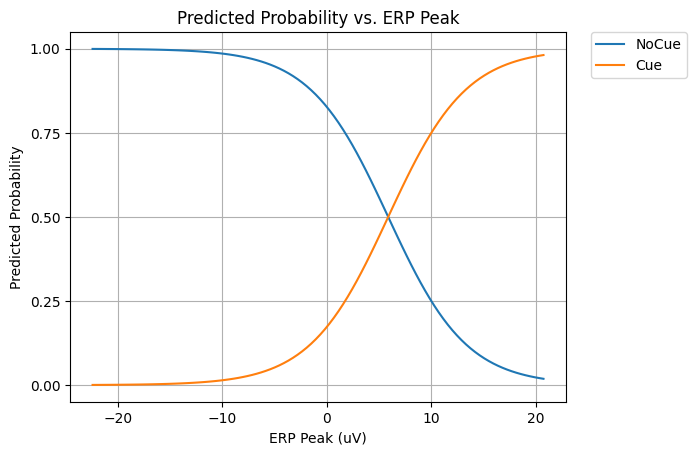

In [22]:
# create range of feature values
min_erp_peak = np.min(X)
max_erp_peak = np.max(X)
erp_peak_vals = np.linspace(min_erp_peak, max_erp_peak, 100)
erp_peak_vals = erp_peak_vals[:, np.newaxis]

# predict probabilities over range of values
pred_probs = clf.predict_proba(erp_peak_vals)
print('The shape of pred_probs is: {}'.format(pred_probs.shape))

# plot predicted probability of each class
plt.plot(erp_peak_vals, pred_probs[:,0], label='NoCue')
plt.plot(erp_peak_vals, pred_probs[:,1], label='Cue')
plt.xlabel('ERP Peak (uV)')
plt.ylabel('Predicted Probability')
plt.title('Predicted Probability vs. ERP Peak')
plt.yticks(np.arange(0,1.1,0.25))
plt.grid()
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
plt.show()


Note that `predict_proba` returns a matrix with the same number of rows as the samples we passed in `erp_peak_vals`, and two columns, one for each class (NoCue or Cue). Since we only have two classes, the probabilities of NoCue and Cue will add to 1 for each sample. This makes one of them redundant, so for future plotting we will drop the NoCue one. 

It is helpful to plot our classes with the data points layered on top, which helps us better visualize the performance of the fit and whether it is falling prey to some issues that will be discussed later.

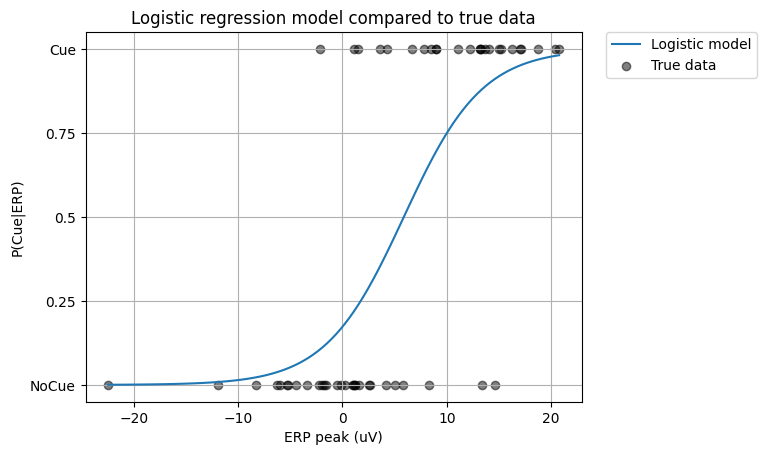

In [23]:
plt.plot(erp_peak_vals, pred_probs[:,1], label='Logistic model')
plt.scatter(X, y, c='k', alpha=0.5, label='True data')
plt.xlabel('ERP peak (uV)')
plt.ylabel('P(Cue|ERP)')
plt.title('Logistic regression model compared to true data')
plt.yticks(np.arange(0,1.1,0.25))
plt.gca().set_yticklabels(['NoCue', '0.25', '0.5', '0.75', 'Cue'])
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
plt.grid()
plt.show()

The logistic function seems to reflect the p(Cue|EPR) quite well. Its probabiity increases strongly after the bulk of the NoCue ERP peaks, and is near 1 when only Cue ERP peak values remain. Instead of describing our logistic fit qualitatively, it would be better to do so quantitatively, using the parameters we discussed before, location and scale. However, here we will have to make things a little more complicated by changing how we parameterize the model. This initial pain is worth it though, because later it will give us far more freedom in how we can use the logistic function.

### Interpreting
The parameters of the logistic function tell us how it asigns a class probability to a measure. When we first introduced it, we used location and scale parameters. These are not used by the `LogisticRegression` class. Instead, it is formulated as:

$$ \sigma(x) = \frac{1}{1+e^{-(b+wx)}} $$

Here $b$ stands for the *bias* or *intercept*, which is similar, but not exactly the same as the location parameter. $w$ is the slope of the dependence on $x$, and is similar, but not exactly the same as the scale parameter.

How do these new parameters affect the logisitic function?


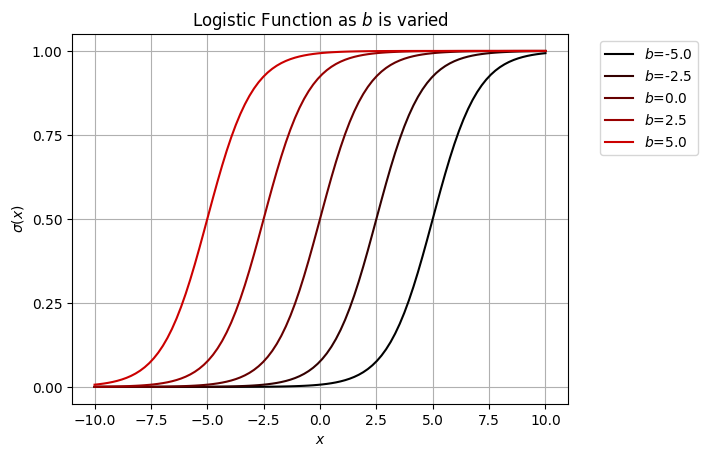

In [24]:
def logistic(x, b=0, w=1):
    return 1 / (1 + np.exp(-(w * x + b)))

# plot the logistic function as b is varied
x = np.linspace(-10, 10, 100)
b_list = np.arange(-5,6,2.5)
for idx, b in enumerate(b_list):
    plt.plot(x, logistic(x, b=b), label=f'$b$={b}', color=[idx/len(b_list), 0, 0])
#plot legend outside axes
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
plt.yticks(np.arange(0,1.1,.25))
plt.xlabel('$x$')
plt.ylabel('$\sigma(x)$')
plt.title('Logistic Function as $b$ is varied')
plt.grid()
plt.show()

Looks like $b$ has exactly the same effect as location, but what if we vary $w$?

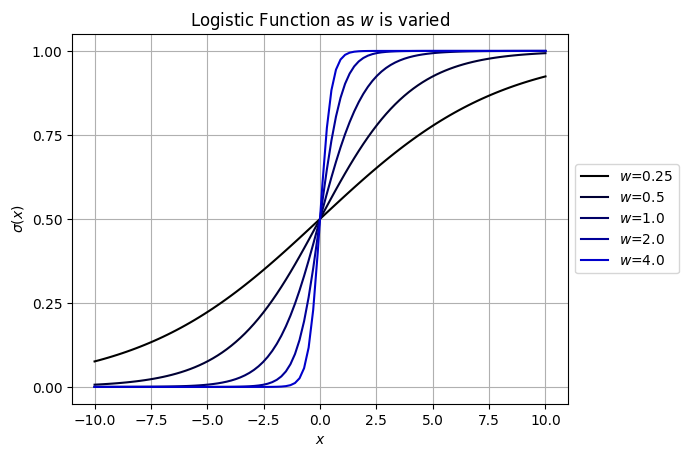

In [25]:
# plot logistic function as w is varied
w_list = np.power(2.0, np.arange(-2, 3))

for idx, w in enumerate(w_list):
    plt.plot(x, logistic(x, b=0, w=w), label='$w$={}'.format(w), color=[0,0,idx/len(w_list)])
plt.yticks(np.arange(0, 1.1, 0.25))
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
plt.xlabel('$x$')
plt.ylabel('$\sigma(x)$')
plt.title('Logistic Function as $w$ is varied')
plt.grid()
plt.show()

It may look the same, but look at the colors to the lines. When we increased the scale parameter, the spread of the logistic function decreased. But in this case, increasing the $w$ parameter decreases the spread. And it gets worse, look what happens when $b$ is not set to 0:

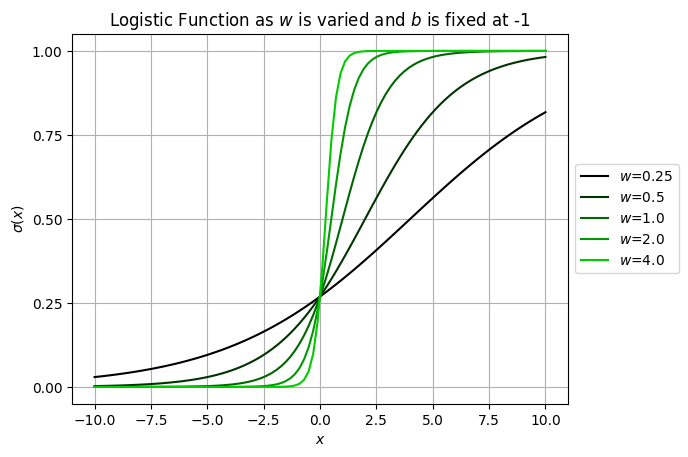

In [26]:
# plot logistic function as w is varied and b is not zero
new_b = -1
for idx, w in enumerate(w_list):
    plt.plot(x, logistic(x, b= new_b, w=w), label='$w$={}'.format(w), color=[0,idx/len(w_list),0])
plt.yticks(np.arange(0, 1.1, 0.25))
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
plt.xlabel('$x$')
plt.ylabel('$\sigma(x)$')
plt.title('Logistic Function as $w$ is varied and $b$ is fixed at {}'.format(new_b))
plt.grid()
plt.show()

When $b$ is not at zero, then changing $w$ affects the location of the logistic function. We can use some simple algebra to resolve these issues.

First, recognize that the loc parameter specifies when the logistic function is equal to 0.5. This happens when $x = 0$:

$$ \begin{align}
        \notag 0.5&=\frac{1}{1+e^{-x}} \\
        \notag 0.5&=\frac{1}{1+e^{-0}} \\
        \notag 0.5&=\frac{1}{1+1} \\
        \notag 0.5&=\frac{1}{2}
    \end{align}
$$

INTRODUCE ALGEBRAIC MANIPULATION TO GET LOCATION
$$ \begin{align}
        \notag 0&=-(b+wx) \\
        \notag 0&=-b-wx \\
        \notag b&=-wx \\
        \notag -\frac{b}{w}&=x
    \end{align}
$$


ADD DESCRIPTION OF DERIVING SCALE PARAMETER
SCALE PARAMETER IS LIKE A COMMON DIVISOR FOR BOTH B AND W. WITH (X+LOC/SCALE), WE CAN THINK OF SCALE AS BEING 1/w, and -b/w... NOT SURE

The location parameter is more important to us when interpreting the logistic function because it tells us when the classifier will label an ERP as arising from a Cue. To get that, we need to pull out the $b$ and $w$ parameters from the fitted `LogisticRegression` object.


In [27]:
# get b, also known as the intercept parameter
b = clf.intercept_
print('The shape of intercept_ is: {}'.format(b.shape))
print('The intercept of our model is {:.2f}'.format(b[0]))

The shape of intercept_ is: (1,)
The intercept of our model is -1.56


`intercept_` is a class variable created once we call the `fit` method. It is a numpy array with a single value. To get $w$, access the `coef_` variable.

In [28]:
# get w from coef_
w = clf.coef_
print('The shape of coef_ is: {}'.format(w.shape))
print('The value of coef_ is: {:.2f}'.format(w[0,0]))

The shape of coef_ is: (1, 1)
The value of coef_ is: 0.27


Now that we have $b$ and $w$, we can precisely position the decision boundary on for our fitted logistic function.

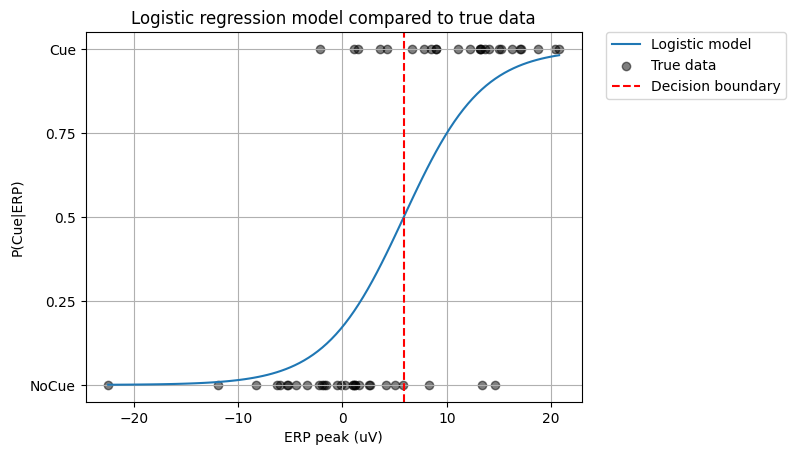

In [29]:
# calculate the decision boundary
dec_bound = -b[0]/w[0,0]

# plot the decision boundary
plt.plot(erp_peak_vals, pred_probs[:,1], label='Logistic model')
plt.scatter(X, y, c='k', alpha=0.5, label='True data')
plt.xlabel('ERP peak (uV)')
plt.ylabel('P(Cue|ERP)')
plt.title('Logistic regression model compared to true data')
plt.yticks(np.arange(0,1.1,0.25))
plt.gca().set_yticklabels(['NoCue', '0.25', '0.5', '0.75', 'Cue'])
plt.axvline(dec_bound, color='r', linestyle='--', label='Decision boundary')
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
plt.grid()
plt.show()

### Prediction
Once the model is fitted, you want to use it to fit new samples. Since we used all our data to fit the model, predicting on the same data would circular. Instead, we can try retraining the model on a subset of the data. This procedure is called cross-validation. 

In [65]:
# num trials of each type to withhold
def train_test_sets(y, k=4):
    # y, array-like, shape (n_samples,)
    # k, int, number of folds

    fold_size = len(y)/k
    test_idxs = np.arange(0, len(y))<=fold_size
    test_idxs = np.random.permutation(test_idxs)
    return test_idxs

np.random.seed(40)

test_idxs = train_test_sets(y, k=5)
X_test = X[test_idxs,:]
y_test = y[test_idxs]

X_train = X[~test_idxs,:]
y_train = y[~test_idxs]

clf = LogisticRegression()
clf.fit(X_train, y_train)
score_test = clf.score(X_test, y_test)

print("Test score: {:.2f}".format(score_test*100))

Test score: 63.64


Lets run the train and testing a few hundred times and see how it performs on average.

{'bodies': [<matplotlib.collections.PolyCollection at 0x168206c70>,
 'cmaxes': <matplotlib.collections.LineCollection at 0x168206700>,
 'cmins': <matplotlib.collections.LineCollection at 0x168206460>,
 'cbars': <matplotlib.collections.LineCollection at 0x14fdf5f40>,
 'cmedians': <matplotlib.collections.LineCollection at 0x168201d90>}

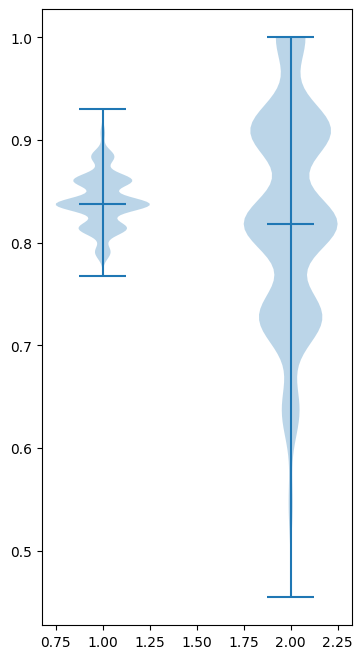

In [99]:
def logreg_traintest(X, y, k):
    test_idxs = train_test_sets(y, k)
    X_test = X[test_idxs,:]
    y_test = y[test_idxs]
    X_train = X[~test_idxs,:]
    y_train = y[~test_idxs]
    clf = LogisticRegression()
    clf.fit(X_train, y_train)
    score_train = clf.score(X_train, y_train)
    score_test = clf.score(X_test, y_test)
    return score_train, score_test

scores_train = np.zeros(1000)
scores_test = np.zeros(1000)
for i in range(1000):
    scores_train[i], scores_test[i] = logreg_traintest(X, y, 5)

# vertically concatenate scores_train and scores_test
scores = np.hstack((scores_train, scores_test))

fig, ax = plt.subplots(figsize=(4,8))
plt.violinplot([scores_train, scores_test], showmedians=True)


Median difference: -0.02


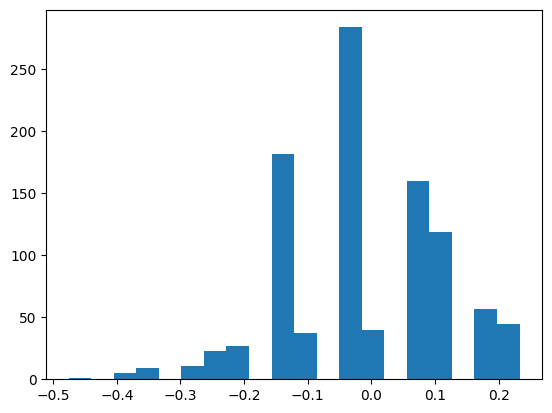

In [101]:
# sign rank comparing scores_test and scores_train

plt.hist(scores_test - scores_train,20)

median_diff = np.median(scores_test - scores_train)
print("Median difference: {:0.2f}".format(median_diff))

In [102]:
8500*1.1


9350.0

## ISSUES WITH FITTING
### UNBALANCED DATASETS
### OVERFITTING

References
G. James et al., An Introduction to Statistical Learning, Springer Texts in Statistics, Chapter 4, https://doi.org/10.1007/978-3-031-38747-0_4
